In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import Markdown

import planet_ruler.observation as pro

from planet_ruler.demo import make_dropdown, load_demo_parameters, display_text
from planet_ruler.plot import plot_3d_solution, plot_topography

# Choose a Target

Run the next cell and choose a target from the dropdown menu.

In [2]:
demo = make_dropdown()
display(demo)

Dropdown(description='Demo:', options=(('Pluto', 1), ('Saturn-1', 2), ('Saturn-2', 3), ('Earth', 4)), value=1)

Load presets using the next cell and then step through the rest of the demo in order.

In [3]:
demo_params = load_demo_parameters(demo)

# Load an Image

In [4]:
Obs = pro.LimbObservation(
    image_filepath=demo_params["image_filepath"], fit_config=demo_params["fit_config"]
)

Let's start out with this image from NASA's New Horizons mission. A couple things to note:

- You can clearly see the 'limb' of Pluto here -- the edge where the dwarf planet meets space.
- We are obviously quite high up (around 18,000 km), which makes the curvature really apparent.

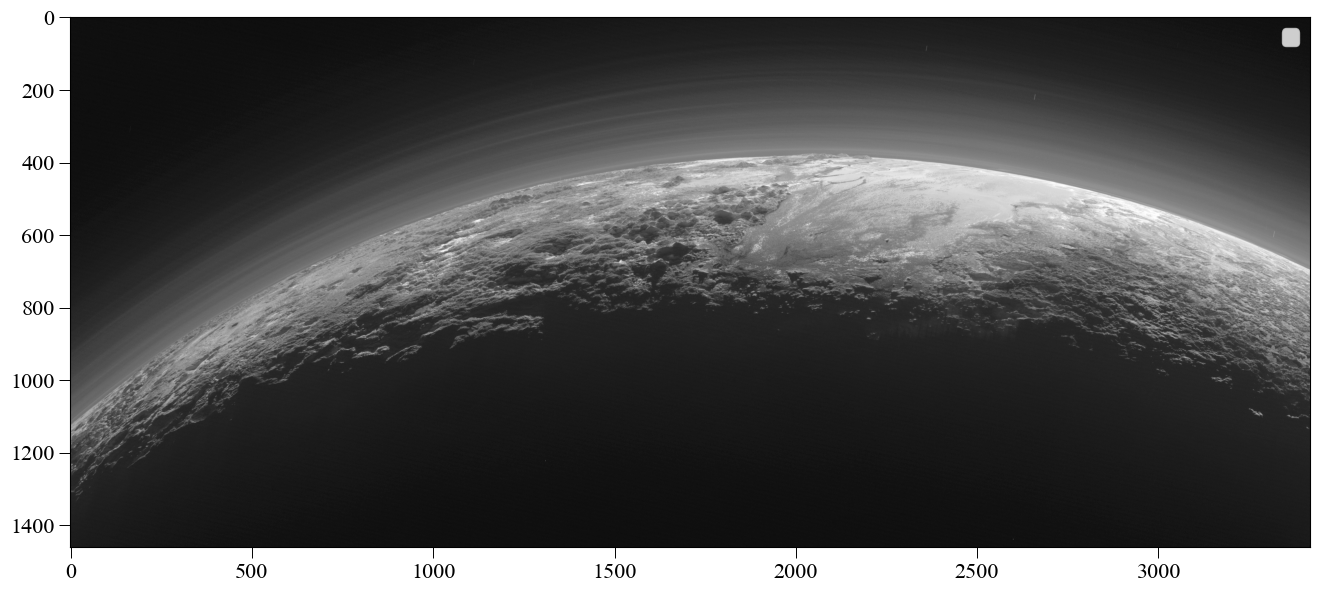

In [5]:
display_text(demo_params["preamble"])

Obs.plot()

# Detect Limb

Next we want to define where the limb is so we can start figuring out the radius. There are many ways to go about this. For example, we could look for regions of high contrast, draw by hand, invent an algorithm, or just use some pre-trained ML. 

For this demo you have the option to use a recent (probably not by the time you read this) pre-trained segmentation model -- 'Segment Anything', or to annotate the limb by hand. The ML route is more automatic but it requires lots of compute power and is more easily fooled than your brain. Feel free to choose either route, or use both and compare!

### Manual Detection

In [6]:
# run this cell if you want to annotate the limb by hand
Obs.limb_detection = "manual"
Obs.detect_limb()

### Automatic Detection

In [ ]:
# run this cell if you want to annotate the limb using ML
Obs.limb_detection = "segmentation"
Obs.detect_limb()
Obs.smooth_limb(method="rolling-median", window_length=1)

We can now take a look at the fitted/annotated limb location.

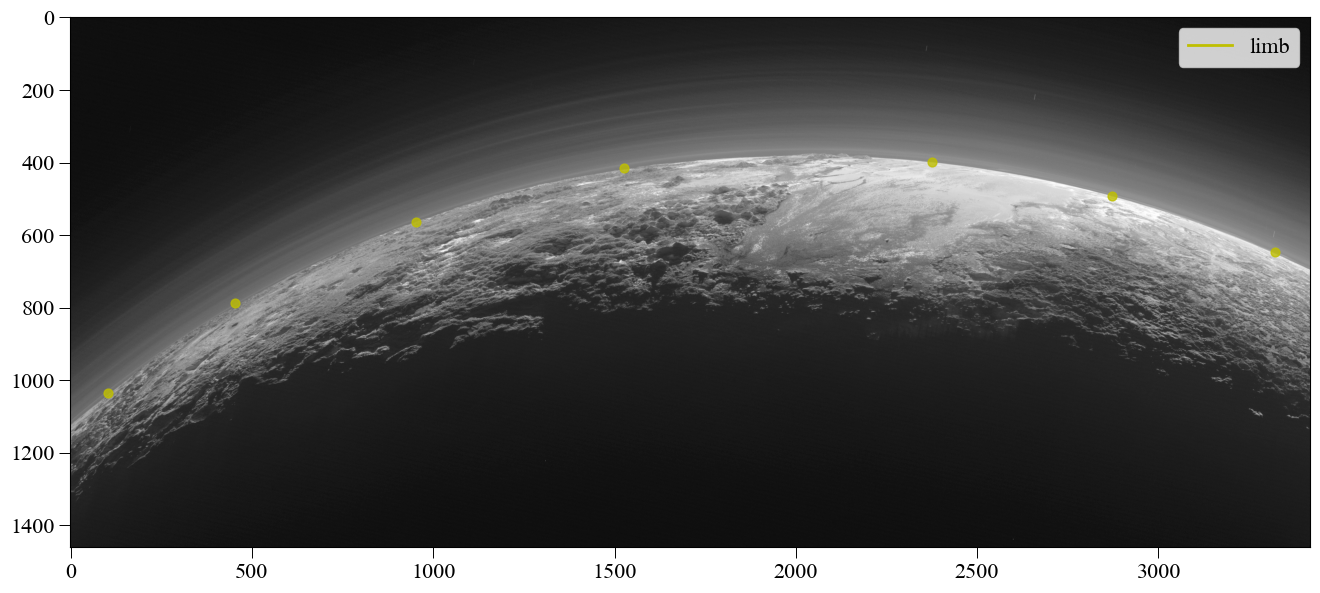

In [7]:
Obs.plot()

Let's add a save point in case we don't want to do all that again.

In [19]:
Obs.save_limb(demo_params["limb_save"])

# Fit Planet Radius

In [8]:
display_text(demo_params["parameter_walkthrough"])

Now for the hard part. We need to deduce the radius of the object below us by leveraging what we know and fitting what we do not.

So -- what do we know?

Let's start with a list of the free parameters in the fit. These are:
- **[r]** Radius of the planet (m)
- **[h]** Height of the camera above the surface (m)
- **[f]** Focal length of the camera (m)
- **[fov]** The angle observed by the camera (degrees)
- **[w]** The width of the detector (m)
- **[x0]** The x-axis principle point (center of the image in pixel space)
- **[y0]** Same as x0 but for the y-axis
- **[theta_x]** Rotation around the x (horizontal) axis, AKA pitch. (radians)
- **[theta_y]** Rotation around the y (vertical) axis, AKA yaw. (radians)
- **[theta_z]** Rotation around the z (toward the limb) axis, AKA roll. (radians)
- **[origin_x]** Horizontal offset from the coordinate origin to the camera (m)
- **[origin_y]** Distance from the coordinate origin to the camera (m)
- **[origin_z]** Height difference from the coordinate origin to the camera (m)

To help the fit we can give initial guesses and boundaries to each of these features. This is a tough optimization with a lot of parameter space, degeneracies, and weird inflection points, so the more help we can give the more likely we are to get somewhere meaningful. Let's step through the parameters.

- **[r]** Radius of the planet (m)
  
> Obviously we are trying to find out **r** so we might not have much to go on here, but that doesn't mean we can't put in some reasonable bounds. We know for example that we are looking at a rocky dwarf planet that is quite spherical which is a clue to the minimum radius. I leave it to the user to do that napkin math -- today let's just put in a guess for the radius at 750 km -- in the ballpark of the truth (1188 km) but not so close to give away the answer. We set the bounds loosely to 600-1900 km.

- **[h]** Height of the camera above the surface (m)

> Here we can make a guess using the known parameters of NASA's New Horizons mission. The NASA image data claims a distance of 18,000 km so we'll start there, plus or minus a few thousand km as boundaries.

- **[f]** Focal length of the camera (m)
- **[fov]** The angle observed by the camera (degrees)
- **[w]** The width of the detector (m)

> These three are grouped together because they are mathematically tied -- see [angle of view](https://en.wikipedia.org/wiki/Angle_of_view_(photography)). By specifying any two, the third is calculable. For that reason we will restrict ourselves to specifying two at a time (to avoid nonsensical combinations). Any two are sufficient, so here we will let f and fov be our free parameters since their initial values were readily available: see the [mission parameters](https://www.dpreview.com/articles/5293237047/nasa-new-horizons-probe-cameras-ralph). We set the focal length to 0.6575 m, and since we're pretty sure about this one, let's give it a very small (0.5cm) tolerance. Field of view will be 5.7 degrees with a 1% uncertainty.

- **[x0]** The x-axis principle point (center of the image in pixel space)

> This one will be set automatically and fixed, assuming the camera has a CCD centered on the optical axis.

- **[y0]** Same as x0 but for the y-axis

> Same as y0.

- **[theta_x]** Rotation around the x (horizontal) axis, AKA pitch. (radians)
- **[theta_y]** Rotation around the y (vertical) axis, AKA yaw. (radians)
- **[theta_z]** Rotation around the z (toward the limb) axis, AKA roll. (radians)

> These describe where the camera is pointing. We start it in the rough direction the limb should be given our assumptions so far about the height and radius, but don't give any real constraints -- i.e., they are loose enough that it can point wherever it wants.

- **[origin_x]** Horizontal offset from the object in question to the camera (m)
- **[origin_y]** Distance from the object in question to the camera (m)
- **[origin_z]** Height difference from the object in question to the camera (m)

> These tell us where the camera is in space relative to the coordinate origin. But since we decide where the origin is, we can just set it to equal the camera position. Now these are all zero by definition -- they can be manipulated for demonstration but don't change these if you want to get the correct answer.

You can see the current initial parameter set [here](https://github.com/bogsdarking/planet_ruler/blob/c8c0a39cae7712363491bc60c861d1a2e410b745/config/pluto-new-horizons.yaml).

Let's try that fit!

In [9]:
# Set n_jobs to the number of processors you feel comfortable utilizing.
Obs.fit_limb(max_iter=15000, n_jobs=6, seed=0)

differential_evolution step 1: f(x)= 1505893.0265061955
differential_evolution step 2: f(x)= 1505893.0265061955
differential_evolution step 3: f(x)= 1505893.0265061955
differential_evolution step 4: f(x)= 1505893.0265061955
differential_evolution step 5: f(x)= 1505893.0265061955
differential_evolution step 6: f(x)= 1505893.0265061955
differential_evolution step 7: f(x)= 369023.5786361291
differential_evolution step 8: f(x)= 369023.5786361291
differential_evolution step 9: f(x)= 369023.5786361291
differential_evolution step 10: f(x)= 369023.5786361291
differential_evolution step 11: f(x)= 369023.5786361291
differential_evolution step 12: f(x)= 369023.5786361291
differential_evolution step 13: f(x)= 369023.5786361291
differential_evolution step 14: f(x)= 369023.5786361291
differential_evolution step 15: f(x)= 369023.5786361291
differential_evolution step 16: f(x)= 262128.45112732667
differential_evolution step 17: f(x)= 262128.45112732667
differential_evolution step 18: f(x)= 262128.4511

## Check Fit

### By Eye

Let's take a look at the solution and see if it makes sense. It's not challenging to end up with a fit that doesn't converge well and appears to have nothing to do with the limb in question. If that happens, don't despair! If the limb detection went okay, it usually it means some tweaking of the parameter ranges or optimizer properties is in order.

We can start by looking at the predicted limb given our optimal parameters. If any of these looks wrong, it likely is. Check your posteriors in the next section and you can try to tweak things.

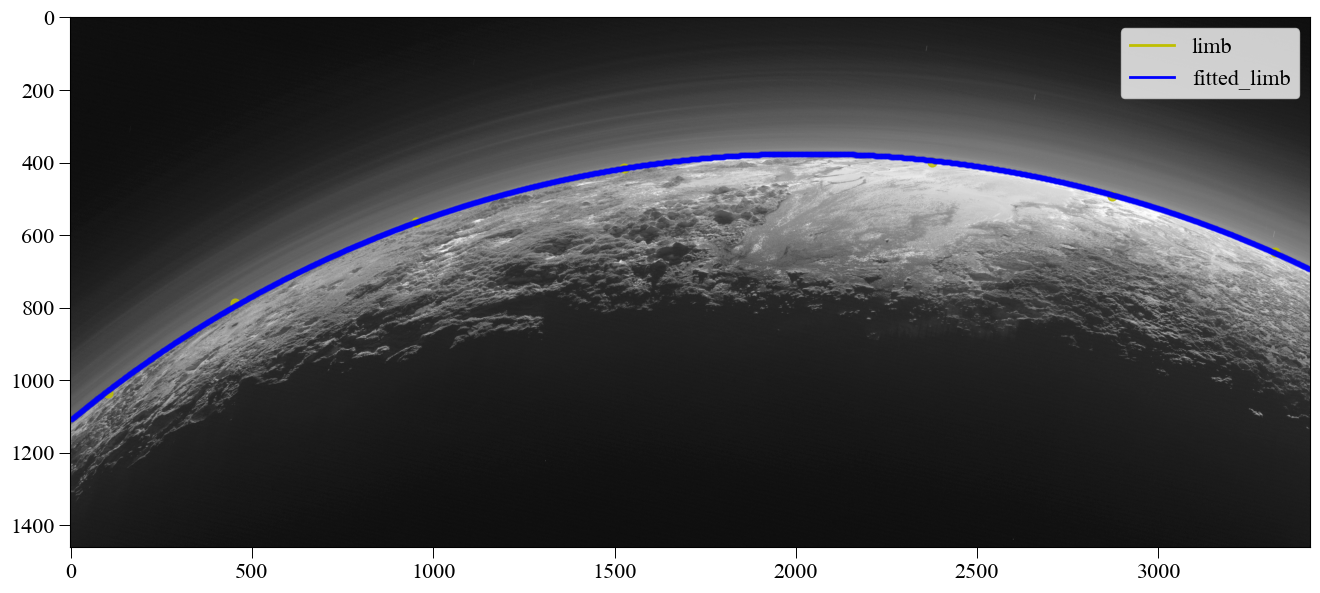

In [10]:
Obs.plot()

We can zoom out a little to see how what the image captures compares to the rest of the planet. There is a lot to that iceberg!

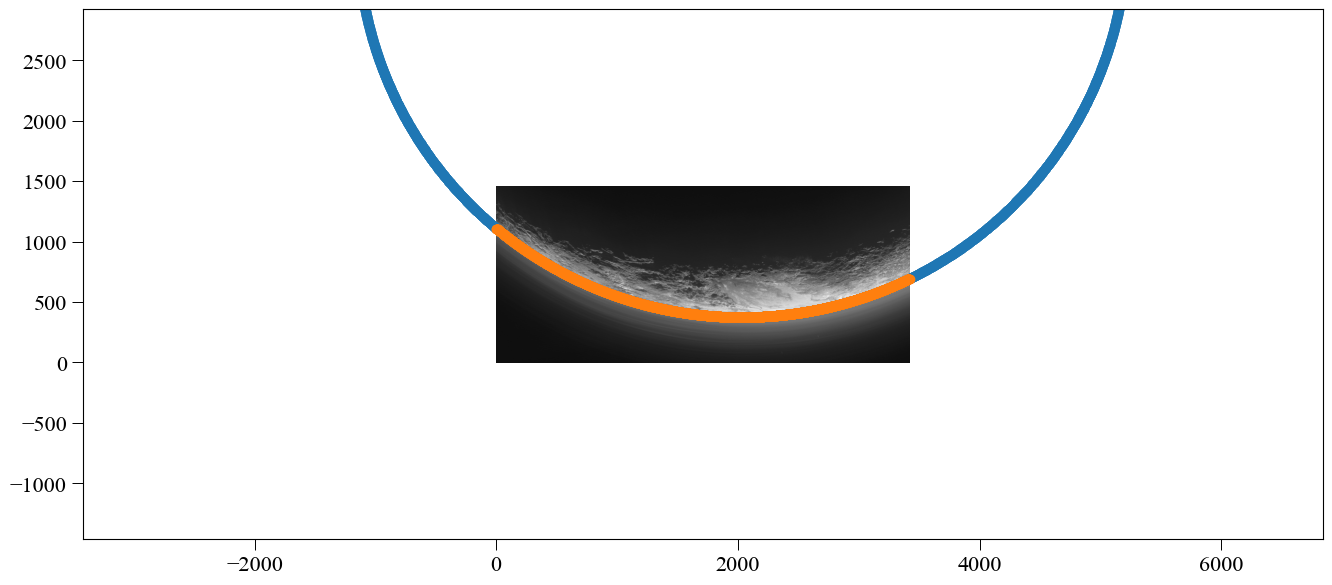

In [11]:
pro.plot_full_limb(
    Obs,
    x_min=-Obs.image.shape[1],
    x_max=2 * Obs.image.shape[1],
    y_min=-Obs.image.shape[0],
    y_max=2 * Obs.image.shape[0],
)

Zooming out even further gives us a real view to what is going on here in three dimensions.

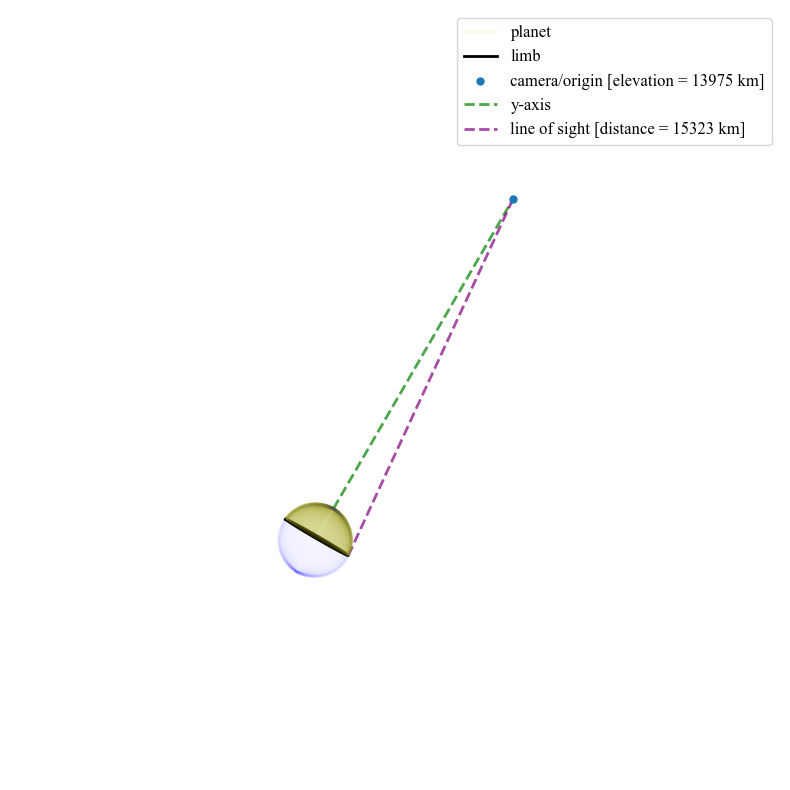

In [12]:
plot_3d_solution(**Obs.best_parameters)

### Posteriors

To understand this section you need to know a bit about what minimizer we used to solve the problem. This is using something called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). It's a (terribly named) way of minimizing a loss function that is non-differentiable. Basically it simulates the 'evolution' of a population composed of parameter value sets. So [r=1, h=2, etc.] could be one unit of the population. These units are mutated and combined over many generations where only the best-fitting survive. When we end the simulation we have an optimal parameter set and a population that is hopefully still competitive. We can think of that population as something like a 'posterior', or measure of uncertainty in each parameter's observed value. Another totally valid method of optimization would have been a Bayesian MCMC and it would also give us posterior distributions that we could check out.

Below we plot all these populations/posteriors and see if they look good. What is good? Ideally they should form a concave U-shape around the best value and not be too much up against either of the limits we imposed in the fit. If the latter is taking place, we might not be reaching the true minimum and it's hard to take the results too seriously. In that case, try the fit again but move the constraints out a little to give the fit some breathing room. I say a little bit because you don't want to make the constraints too wide either -- there really is a sweet spot that doesn't explicitly block the best parameter values, but gives the minimizer enough to work with that it can arrive there in our lifetimes.

I already went through the trial and error to get the following posteriors to look right -- if implementing the code on a new image, take these an example of what to shoot for.

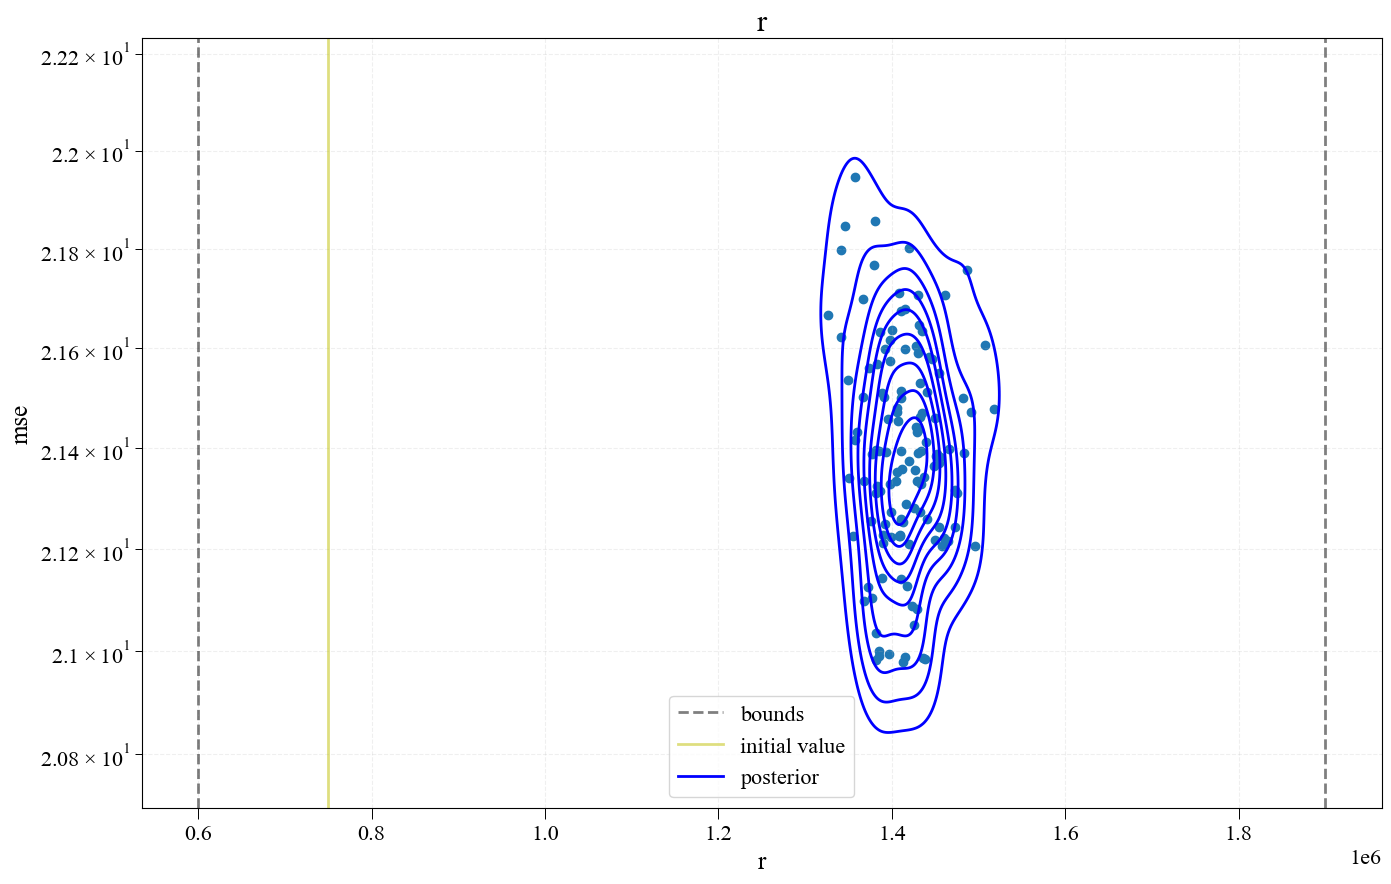

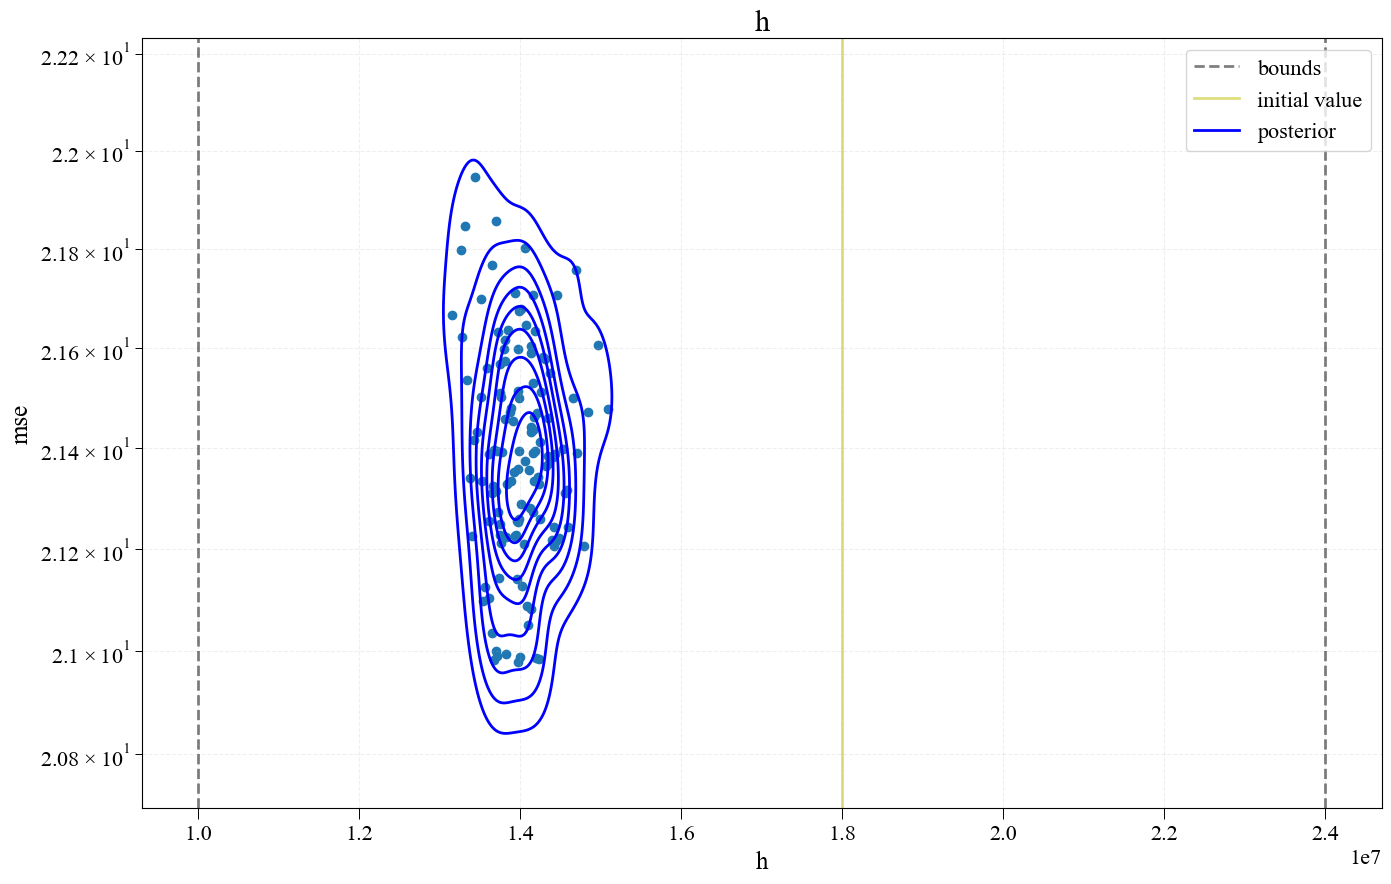

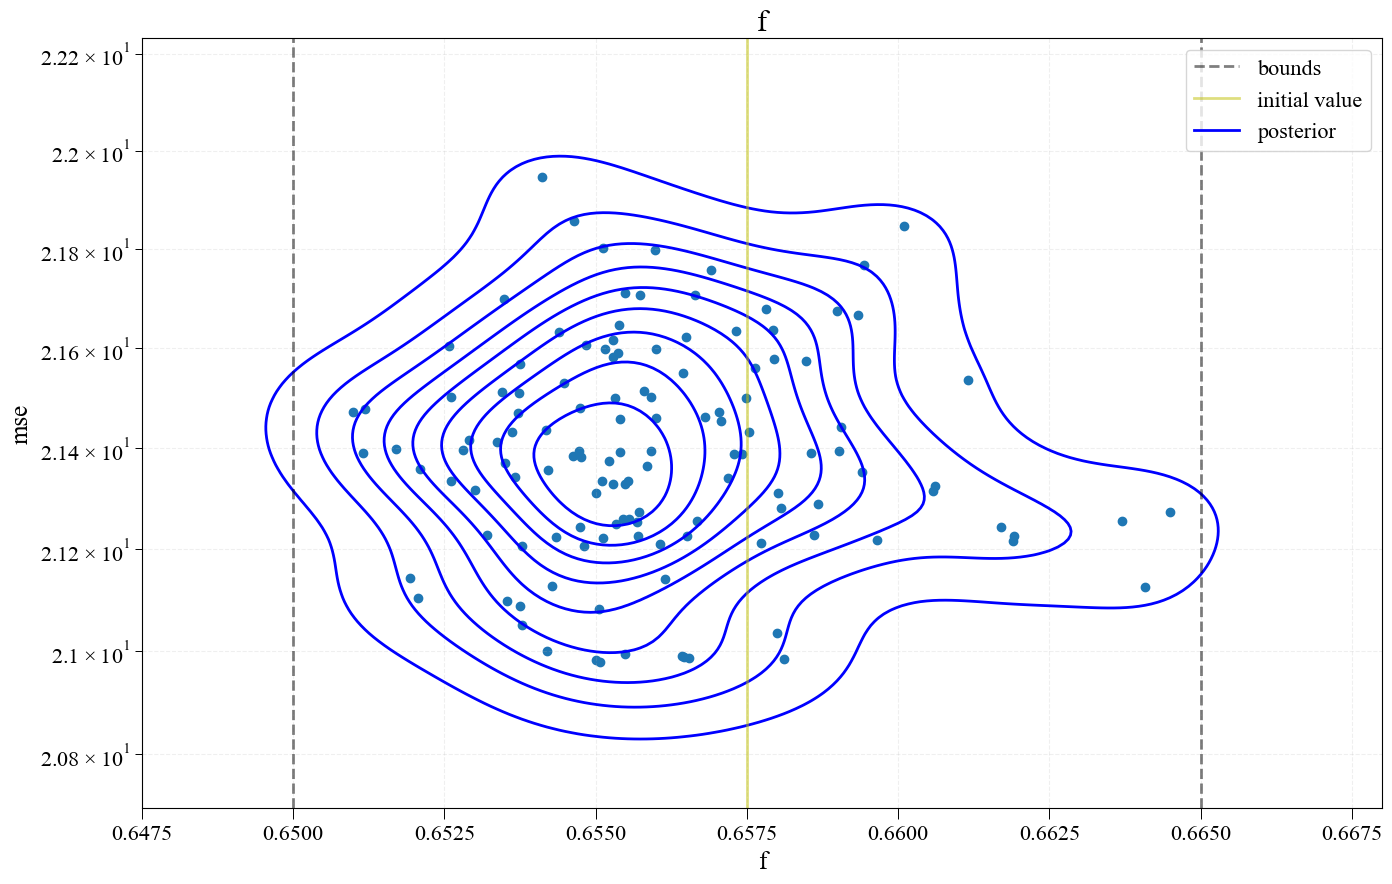

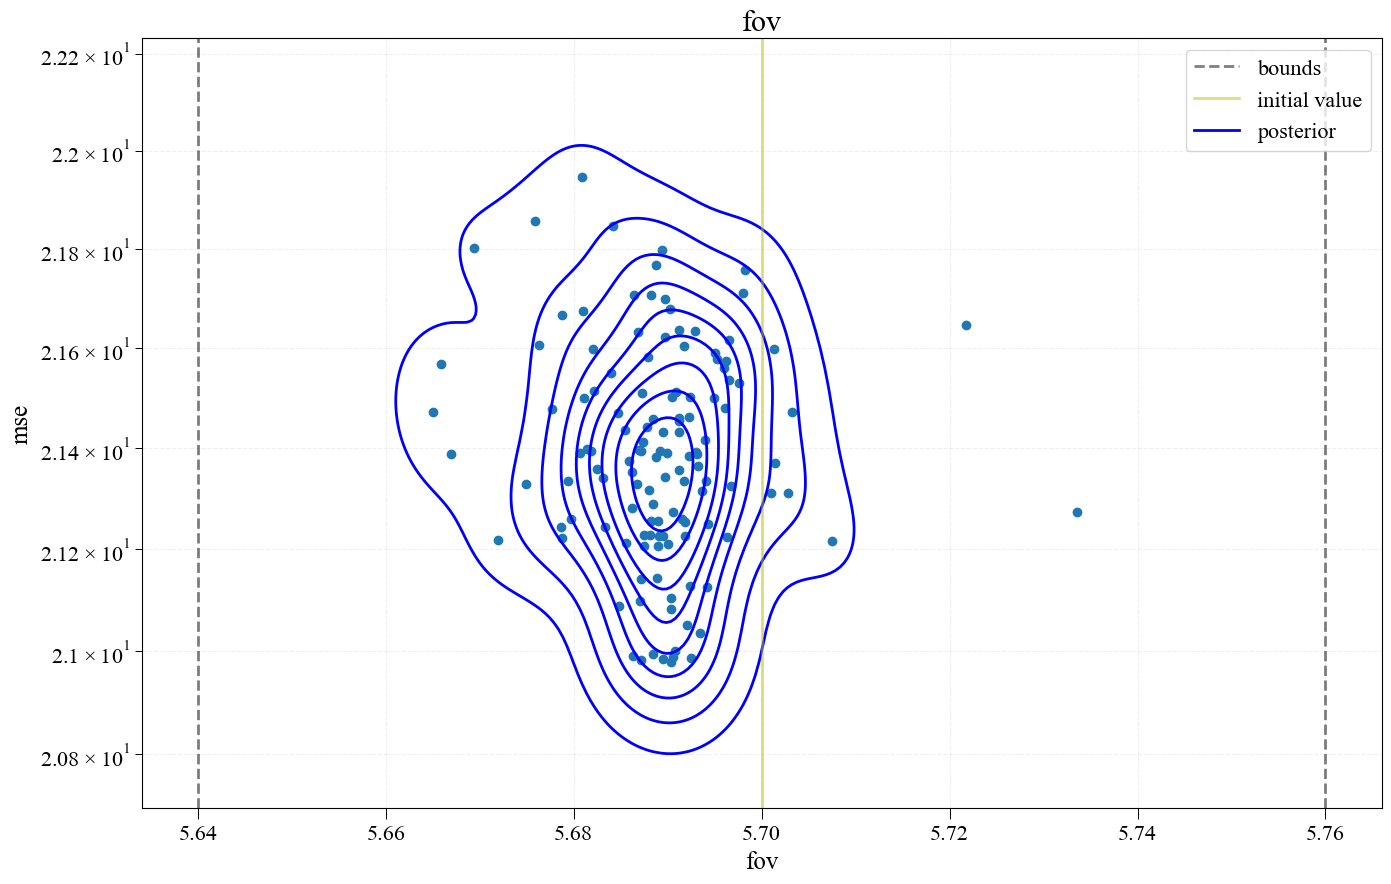

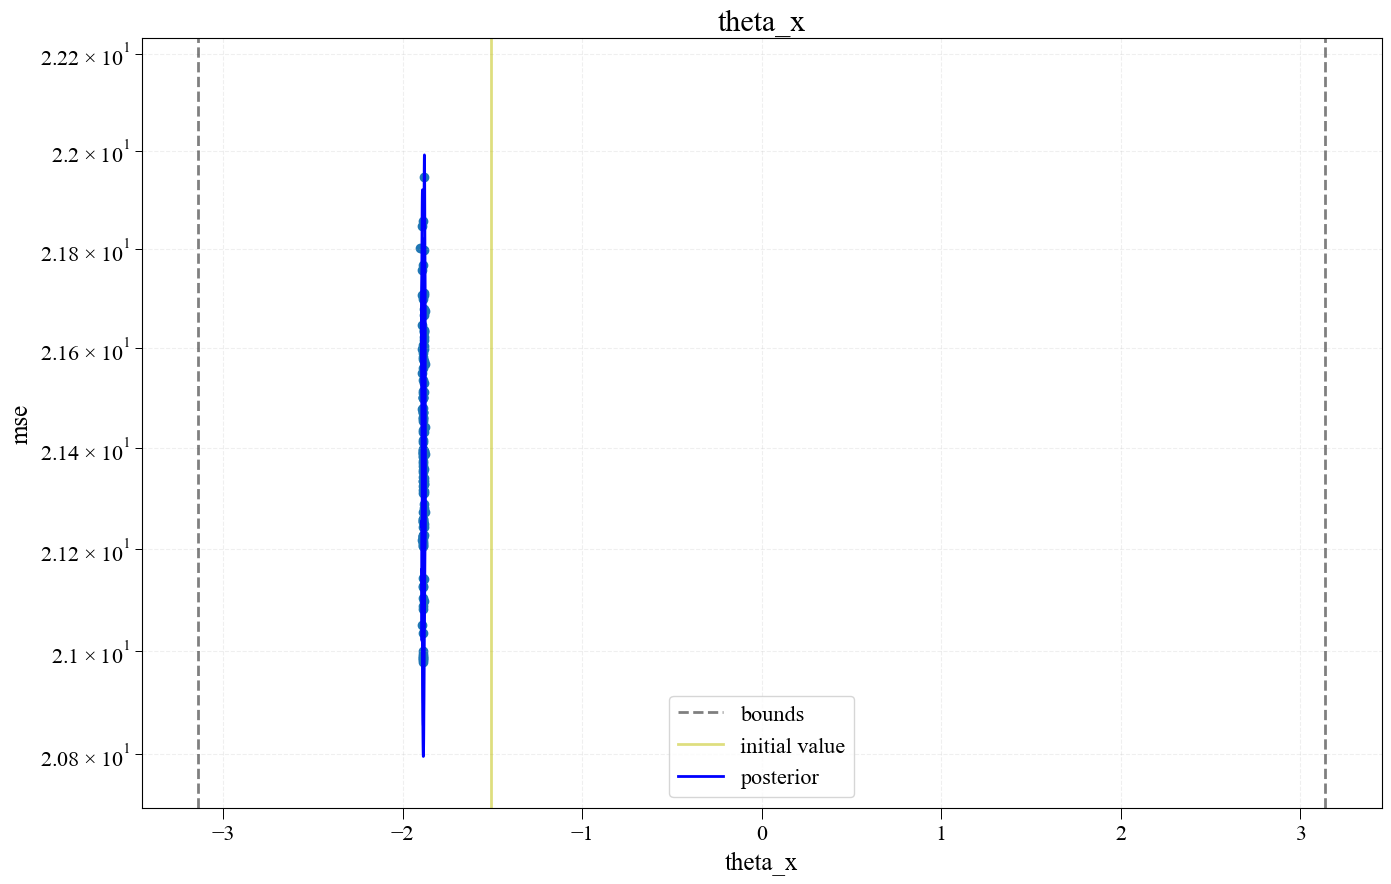

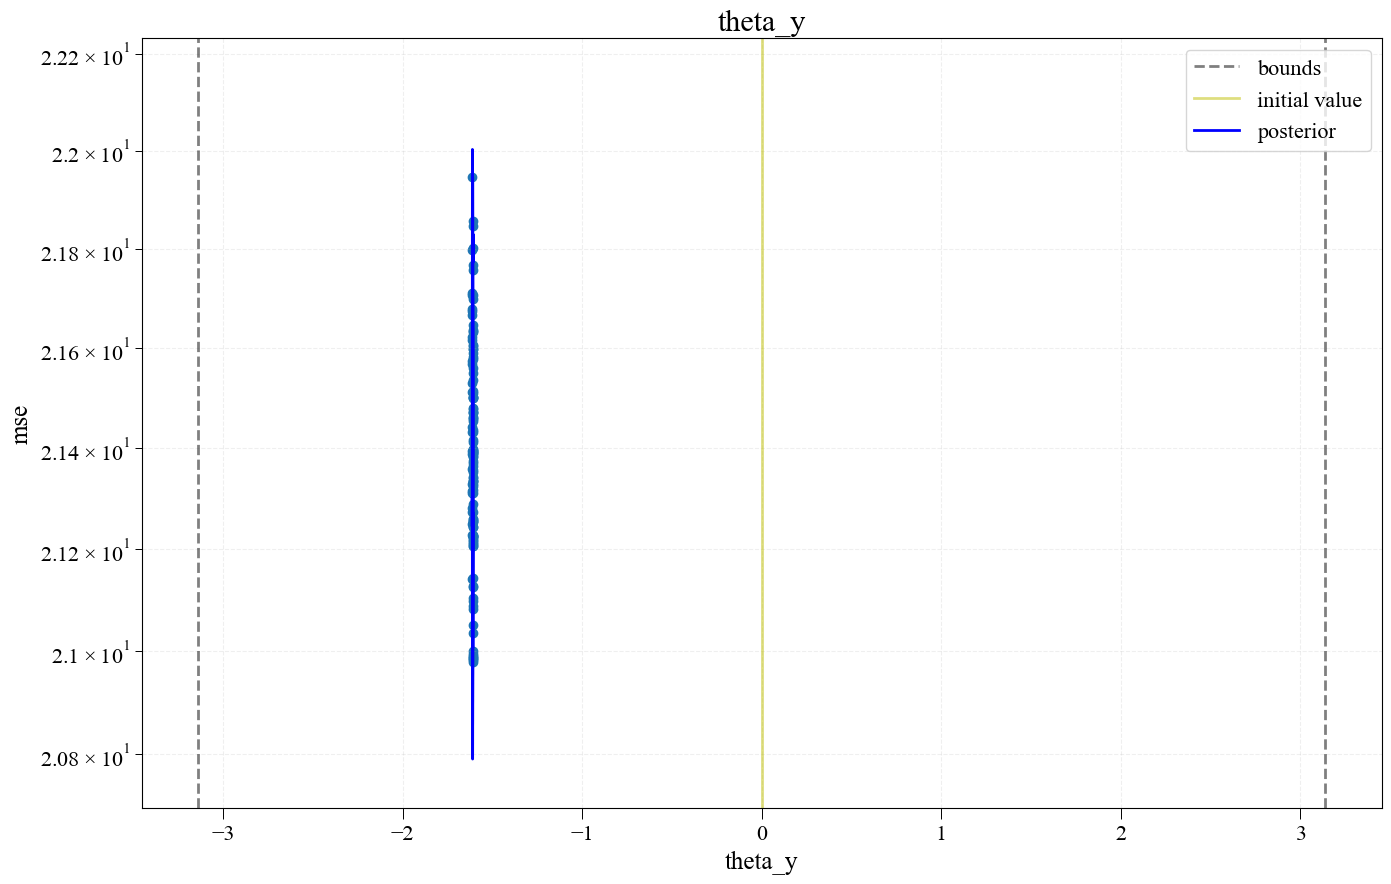

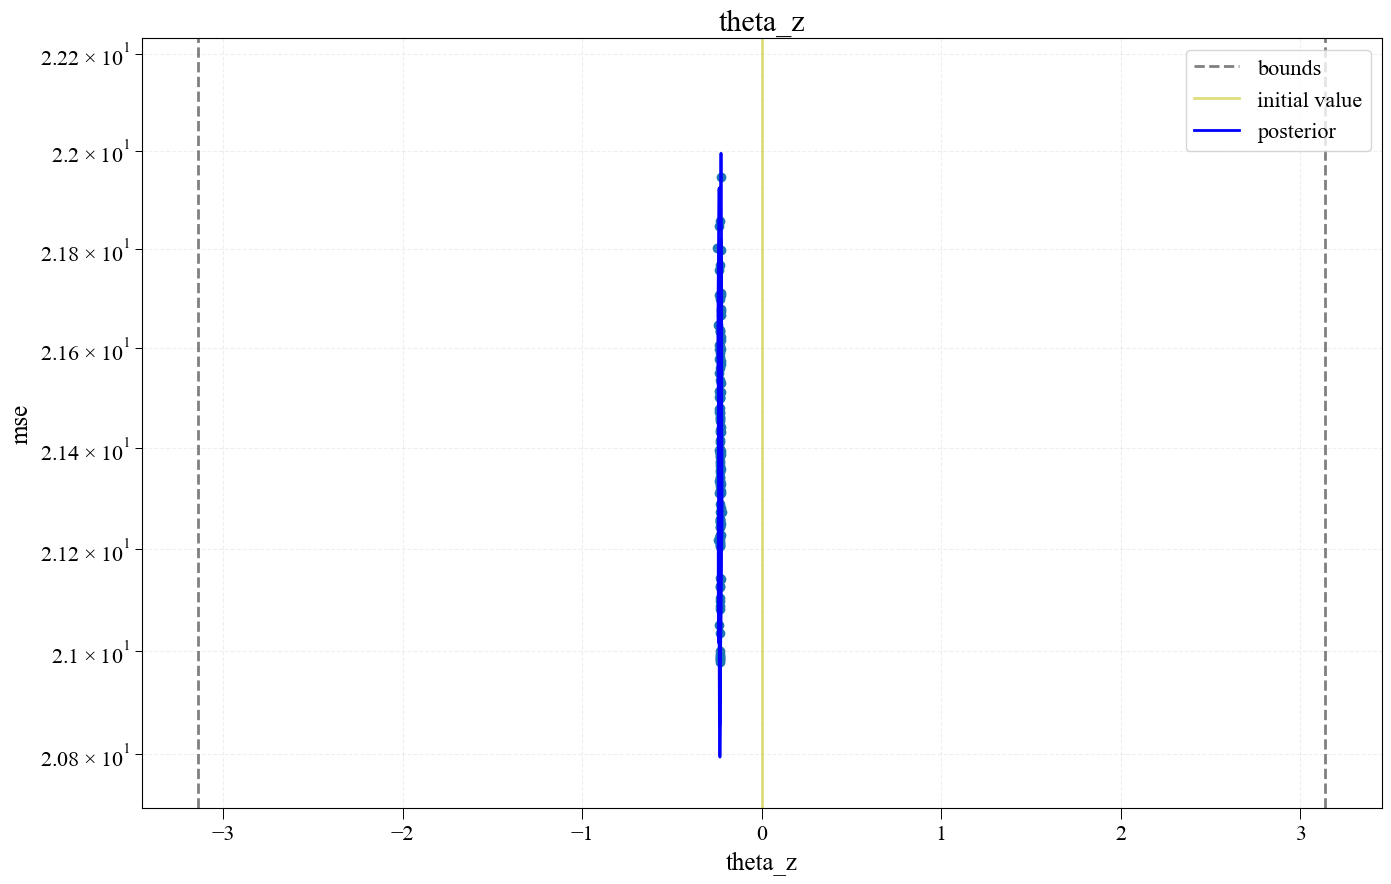

In [13]:
pro.plot_diff_evol_posteriors(Obs, show_points=True)

If you prefer hard numbers, here's a summary.

In [14]:
pro.unpack_diff_evol_posteriors(Obs).describe()

,r,h,f,fov,num_sample,theta_x,theta_y,theta_z,mse
count,1.280000e+02,1.280000e+02,128.000000,128.000000,128.0,128.000000,128.000000,128.000000,128.000000
mean,1.414491e+06,1.399582e+07,0.656003,5.689093,5000.0,-1.885277,-1.610966,-0.233051,21.390364
std,3.690659e+04,3.702359e+05,0.002616,0.008670,0.0,0.003798,0.000639,0.003785,0.212293
min,1.326729e+06,1.315658e+07,0.650993,5.665048,5000.0,-1.902339,-1.613241,-0.250168,20.979328
25%,1.387860e+06,1.373218e+07,0.654326,5.686079,5000.0,-1.887053,-1.611081,-0.234750,21.244945
50%,1.411177e+06,1.397778e+07,0.655488,5.689403,5000.0,-1.885678,-1.610889,-0.233411,21.389051
75%,1.435109e+06,1.420950e+07,0.657430,5.692420,5000.0,-1.884283,-1.610695,-0.232056,21.532496
max,1.517799e+06,1.508685e+07,0.664497,5.733550,5000.0,-1.875099,-1.608180,-0.222249,21.947638


# The Answer!

At long last. After convincing ourselves that we can trust our results, let's take a look.

In [15]:
final_params = Obs.init_parameter_values.copy()
final_params.update(Obs.best_parameters)
fitted_radius = final_params["r"] / 1000
fit_population = pro.unpack_diff_evol_posteriors(Obs)
fine_uncertainty = fit_population["r"].std() / 1000
rough_uncertainty = np.ptp(fit_population["r"]) / 1000
pct_error = (
    (fitted_radius - demo_params["true_radius"]) / demo_params["true_radius"] * 100
)

print(
    f"Our estimate of {demo_params['target']}'s radius is{fitted_radius: .1f} \u00b1{rough_uncertainty: .0f} kilometers."
)
print(
    f"That puts us {pct_error: .1f}% away from the true value of {demo_params['true_radius']} km."
)

Our estimate of Pluto's radius is 1413.0 ± 191 kilometers.
That puts us  18.9% away from the true value of 1188 km.


The value is quite close to the truth. I wouldn't plan a space trip around it but it isn't bad for a single image and rough idea of what camera was used!

See below where all the other parameters ended up relative to their initial values.

In [16]:
pro.package_results(Obs)

,fit value,initial value
parameter,,
r,1.412964e+06,7.500000e+05
h,1.397506e+07,1.800000e+07
f,6.550722e-01,6.575000e-01
fov,5.690382e+00,5.700000e+00
theta_x,-1.885218e+00,-1.508843e+00
theta_y,-1.610968e+00,0.000000e+00
theta_z,-2.329585e-01,0.000000e+00
